### Data Preprocessing

This notebook contains data preprocessing for the  [BEA2019 wi+locness dataset](https://www.cl.cam.ac.uk/research/nl/bea2019st/).

The dataset consists of files in the M2 format, which are split into train, development and test sets. 

In the preprocessing stage, the files are read from the M2 format and the sentences are corrected in accordance with the annotations. The UNK annotations are removed.
Finally, statistics for each split are plotted using matplotlib


In [1]:
train_file = "data/wi+locness/ABC.train.gold.bea19.m2"
devA_file = "data/wi+locness/A.dev.gold.bea19.m2"
devB_file = "data/wi+locness/B.dev.gold.bea19.m2"
devC_file = "data/wi+locness/C.dev.gold.bea19.m2"
test_file = "data/wi+locness/N.dev.gold.bea19.m2"

In [2]:
def read_m2_file(file_path):
    """
    Read file and store sentences and their annotations in a list of tuples
    """
    data = []

    with open(file_path, 'r') as file:
        current_sentence = None
        current_annotations = []

        for line in file:
            line = line.strip()
            if line.startswith('S '):
                if current_sentence is not None:
                    data.append((current_sentence, current_annotations))
                current_sentence = line[2:]
                current_annotations = []
            elif line.startswith('A '):
                current_annotations.append(line)

        if current_sentence is not None:
            data.append((current_sentence, current_annotations))

    return data

In [3]:
# read and store data from the M2 file
train_data = read_m2_file(train_file)
dev_data =[]
for dev in [devA_file, devB_file, devC_file]:
  dev_data.extend(read_m2_file(dev))
test_data = read_m2_file(test_file)

# check number of instances in the data
print('number of instances in training data:', len(train_data))
print('number of instances in development data:', len(dev_data))
print('number of instances in testing data:', len(test_data))

number of instances in training data: 34308
number of instances in development data: 3396
number of instances in testing data: 988


In [4]:
def filter_annotations(annotations):
    """
    Filter out annotations of type 'UNK'
    """
    filtered_annotations = []
    for annotation in annotations:
        parts = annotation.split('|||')
        error_type = parts[1].split(':')[0]
        if error_type != 'UNK':
            filtered_annotations.append(annotation)
    return filtered_annotations

In [5]:
def process_data(data):
    """
    Process the data to exclude sentences with no annotations after filtering
    """
    cleaned_data = []
    for sentence, annotations in data:
        filtered_annotations = filter_annotations(annotations)
        # only keep sentences with annotations
        if filtered_annotations:
            cleaned_data.append((sentence, filtered_annotations))
    return cleaned_data

In [6]:
train_data = process_data(train_data)
dev_data = process_data(dev_data)
test_data = process_data(test_data)

# check number of instances in the data
print('number of instances in training data after filtering UNK:', len(train_data))
print('number of instances in development data after filtering UNK:', len(dev_data))
print('number of instances in testing data after filtering UNK:', len(test_data))

number of instances in training data after filtering UNK: 34000
number of instances in development data after filtering UNK: 3368
number of instances in testing data after filtering UNK: 979


After have filtered the data, the sentences are modified according to their annotations in order to get their corrected versions.

In [7]:
def apply_corrections_to_sentence(sentence, annotations):
    """
    Correct sentences based on their annotations
    """
    corrected_sentence = sentence.split()
    cumulative_position_change = 0

    for annotation in annotations:
        if annotation.startswith('A'):
            parts = annotation.split('|||')
            edit_type = parts[1].split(':')[0]
            start_position = int(parts[0].split()[1]) + cumulative_position_change
            end_position = int(parts[0].split()[2]) + cumulative_position_change

            if edit_type == 'M':  # Missing
                corrected_sentence[start_position:start_position] = parts[2].split()  # Insert modified text
                # Update position change
                cumulative_position_change += len(parts[2].split()) - (end_position - start_position)

            elif edit_type == 'R':  # Replacement
                corrected_sentence[start_position:end_position] = parts[2].split()  # Replace text

            elif edit_type == 'U':  # Deletion
                del corrected_sentence[start_position:end_position]
                # Update position change
                cumulative_position_change -= (end_position - start_position)


    return ' '.join(corrected_sentence)


Count error types in each split to plot the statistics at the end.

In [8]:
from collections import Counter
def categorize_errors(annotations):
    """
    Count error types in annotations
    """
    primary_error_types = Counter()
    detailed_error_types = Counter()
    
    for annotation_set in annotations:
        for annotation in annotation_set:
            parts = annotation.split('|||')
            primary_error_type = parts[1].split(':')[0]
            if len(parts[1].split(':')) > 2:
                detailed_error_type = parts[1].split(':')[1] + ':' + parts[1].split(':')[2]
                detailed_error_types[detailed_error_type] += 1
            elif len(parts[1].split(':')) > 1:
                detailed_error_type = parts[1].split(':')[1]
                detailed_error_types[detailed_error_type] += 1
            primary_error_types[primary_error_type] += 1
    
    return primary_error_types, detailed_error_types

In [9]:
def convert_m2_to_dict(m2_data):
    """
    Save data to a dict with source and corrected (target) sentences
    """
    converted_data = []

    for sentence, annotations in m2_data:
        corrected_sentence = apply_corrections_to_sentence(sentence, annotations)
        converted_data.append({'src': sentence, 'tgt': corrected_sentence})

    return converted_data

In [10]:
# convert all loaded m2 data to the desired representation
converted_train_data = convert_m2_to_dict(train_data)
converted_dev_data = convert_m2_to_dict(dev_data)
converted_test_data = convert_m2_to_dict(test_data)


In [11]:
converted_train_data[0]

{'src': 'My town is a medium size city with eighty thousand inhabitants .',
 'tgt': 'My town is a medium - sized city with eighty thousand inhabitants .'}

In [12]:
def count_errors_per_dataset(m2_data):
    annotations = [ann for _, ann in m2_data]
    return categorize_errors(annotations)

In [13]:
# Count errors per dataset
train_primary_error_counts, train_detailed_error_counts = count_errors_per_dataset(train_data)
dev_primary_error_counts, dev_detailed_error_counts = count_errors_per_dataset(dev_data)
test_primary_error_counts, test_detailed_error_counts = count_errors_per_dataset(test_data)

In [14]:
import matplotlib.pyplot as plt

def plot_histogram(ax, data, title, rotation=90):
    labels = list(data.keys())
    values = list(data.values())
    
    # Sort the data by values in descending order
    sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]
    
    ax.bar(sorted_labels, sorted_values)
    
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel("Error Type")
    ax.set_ylabel("Count")
    
    ax.set_xticks(range(len(sorted_labels)))
    ax.set_xticklabels(sorted_labels, rotation=rotation)
    


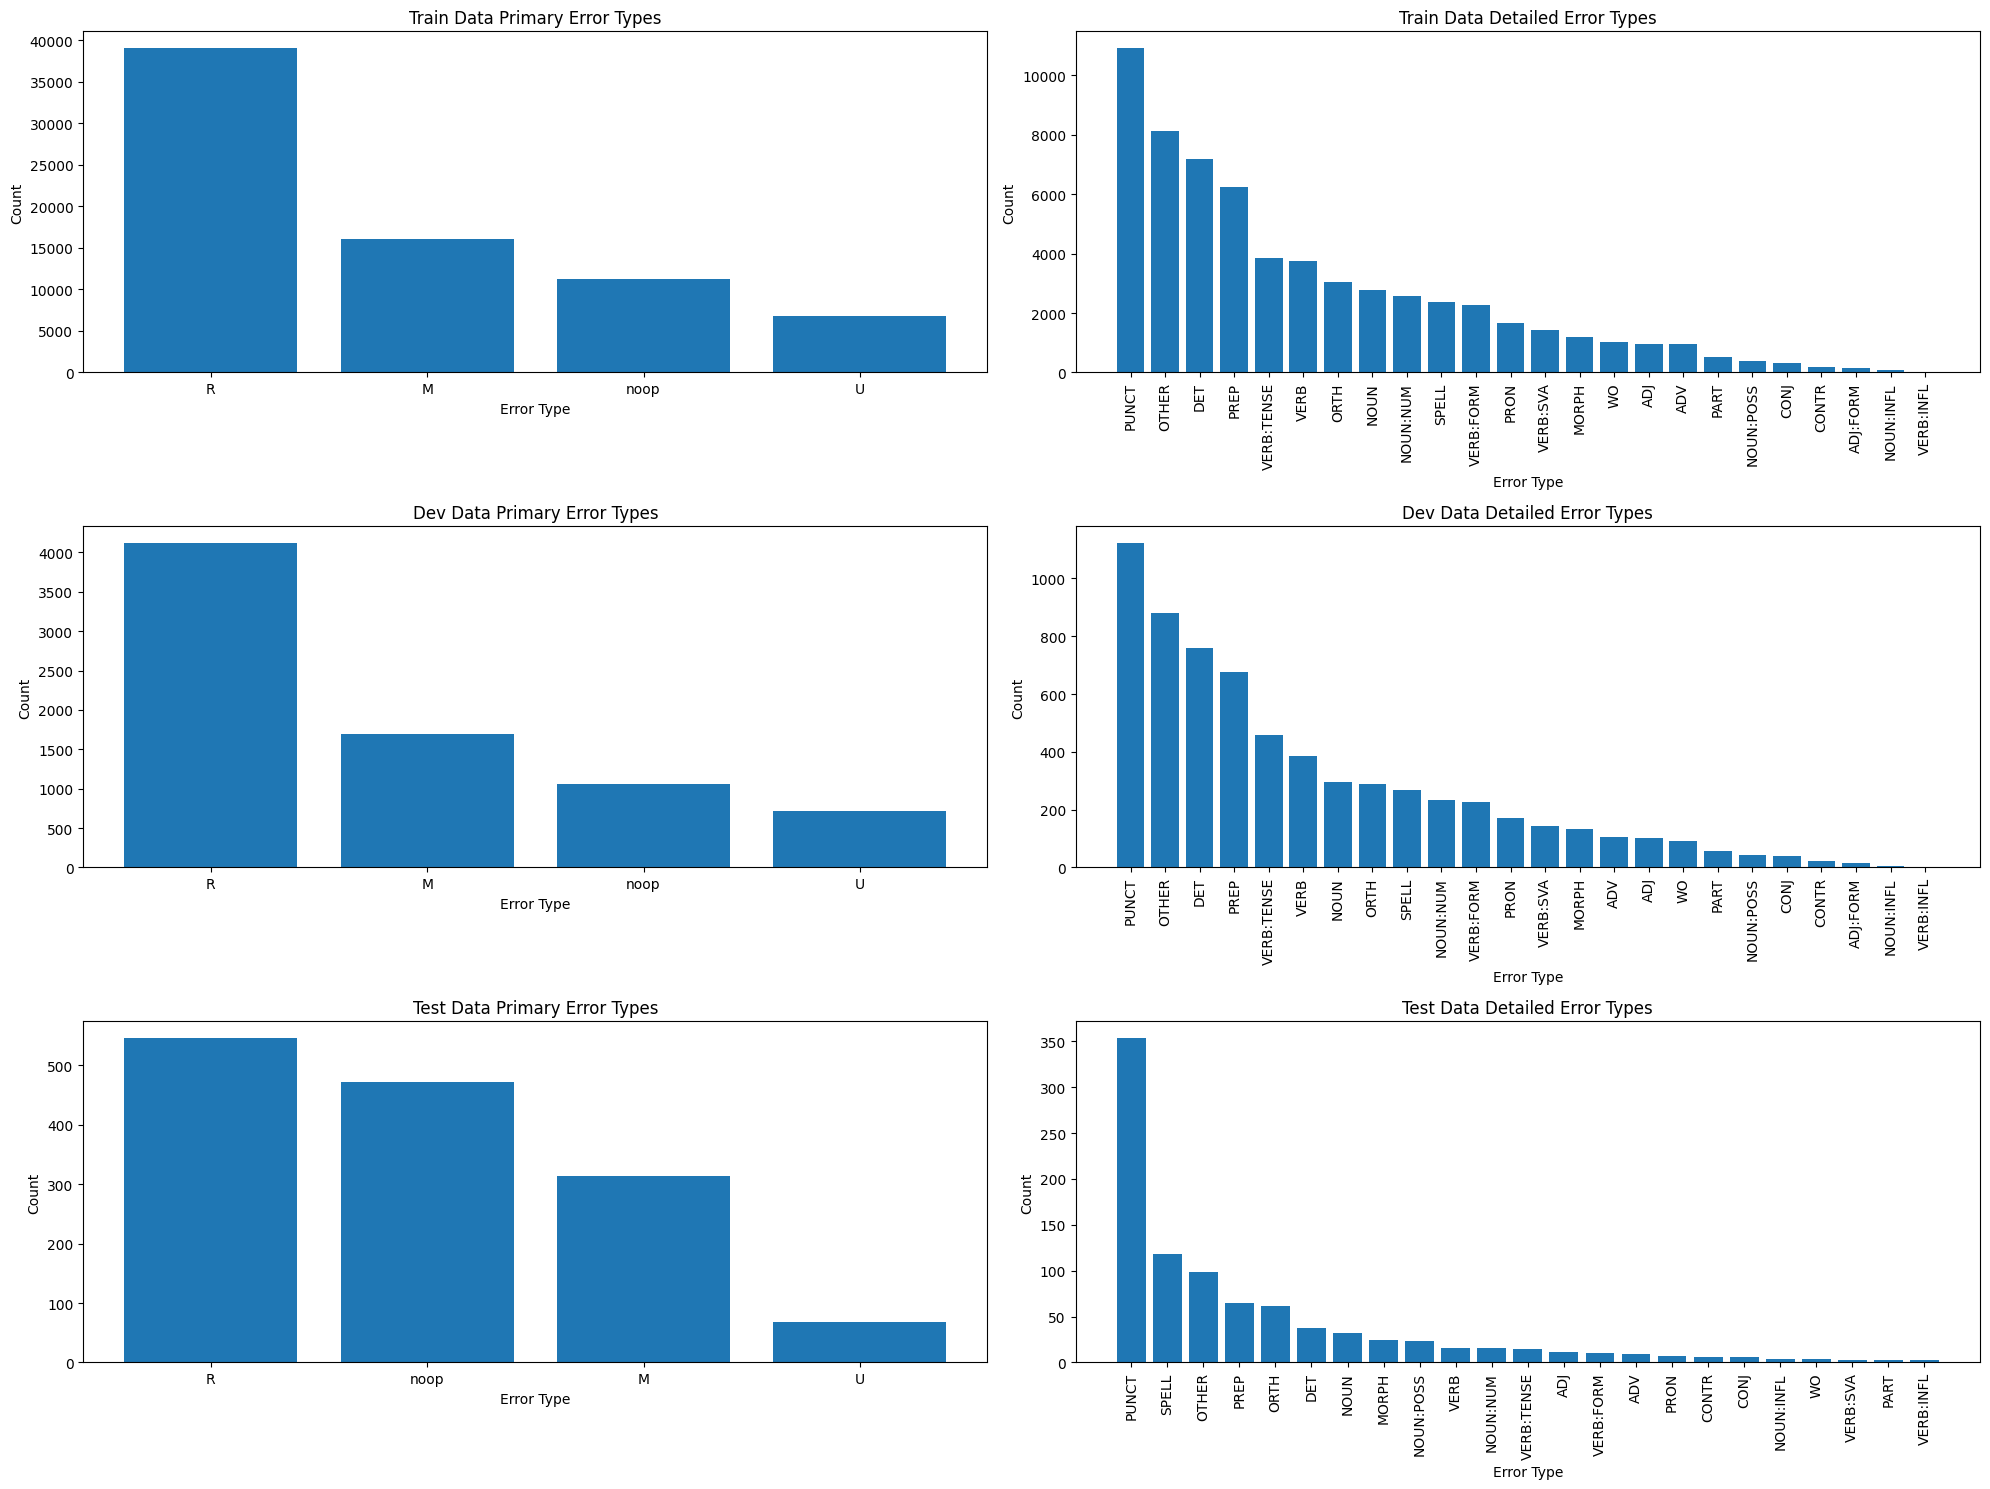

In [15]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Plot primary error types
plot_histogram(axes[0, 0], train_primary_error_counts, "Train Data Primary Error Types", rotation=0)
plot_histogram(axes[1, 0], dev_primary_error_counts, "Dev Data Primary Error Types", rotation=0)
plot_histogram(axes[2, 0], test_primary_error_counts, "Test Data Primary Error Types", rotation=0)

# Plot detailed error types
plot_histogram(axes[0, 1], train_detailed_error_counts, "Train Data Detailed Error Types")
plot_histogram(axes[1, 1], dev_detailed_error_counts, "Dev Data Detailed Error Types")
plot_histogram(axes[2, 1], test_detailed_error_counts, "Test Data Detailed Error Types")

plt.tight_layout()
plt.show()

Saving files in json format:

In [18]:
import json

data_dict = {
    'train': converted_train_data,
    'dev': converted_dev_data,
    'test': converted_test_data
}

for dataset_name in ['train', 'dev', 'test']:
    filename = f'data/preprocessed_data/{dataset_name}.json'
    data_to_save = data_dict[dataset_name]
    
    with open(filename, 'w') as f:
        json.dump(data_to_save, f, indent=4)